# This file is for generating different confusion matricies!

In [1]:
# Import libraries
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP/')

from experiments.model_helpers import *
import pandas as pd
from sklearn.metrics import confusion_matrix



#* Load in the data
static2024 = pd.read_csv('~/PF-GAP/data/static2024.csv')
static2023 = pd.read_csv('~/PF-GAP/data/static2023.csv')
static2022 = pd.read_csv('~/PF-GAP/data/static2022.csv')
static2025 = pd.read_csv('~/PF-GAP/data/static2025.csv')
time_series = np.array(pd.read_csv('~/PF-GAP/data/time_series.csv'))
labels = pd.read_csv('~/PF-GAP/data/labels.csv')
labels = np.array(labels).flatten()

time_series_hourly = pd.read_csv("~/PF-GAP/data/HourlyReturnsSingleYear.csv")
labels_hourly = time_series_hourly.pop("Sector").values
tickers = time_series_hourly.pop("Ticker").values


# Hourly Data
static_data = pd.read_csv("~/PF-GAP/data/sp500_fundamentals_combined.csv")
static_hourly = static_data[static_data['Year'] == 2024].reset_index(drop=True)
static_hourly = static_hourly.set_index('Ticker').reindex(tickers).reset_index().drop(columns=["Ticker", "Year"])
if static_hourly.isnull().values.any():
    static_hourly = static_hourly.fillna(static_hourly.median(numeric_only=True))

#Train test splits
from sklearn.model_selection import train_test_split
X_train_hourly, X_test_hourly, y_train_hourly, y_test_hourly, static_train_hourly, static_test_hourly = train_test_split(
    time_series_hourly, labels_hourly, static_hourly, test_size=0.2, random_state=42)

X_train_daily, X_test_daily, y_train_daily, y_test_daily, static_train_daily, static_test_daily = train_test_split(
    time_series, labels, static2024, test_size=0.2, random_state=42)

print("-- Data Loaded --")

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

-- Data Loaded --


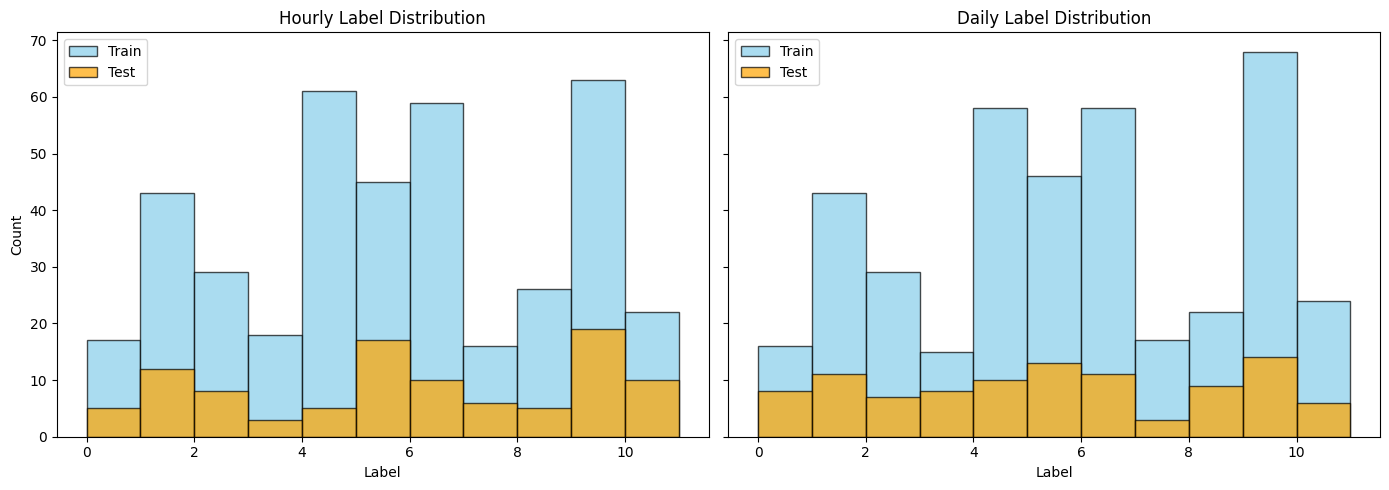

In [19]:
import matplotlib.pyplot as plt

# Plot label distributions for hourly and daily
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(y_train_hourly, bins=range(12), alpha=0.7, label='Train', color='skyblue', edgecolor='black')
axes[0].hist(y_test_hourly, bins=range(12), alpha=0.7, label='Test', color='orange', edgecolor='black')
axes[0].set_title('Hourly Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].hist(y_train_daily, bins=range(12), alpha=0.7, label='Train', color='skyblue', edgecolor='black')
axes[1].hist(y_test_daily, bins=range(12), alpha=0.7, label='Test', color='orange', edgecolor='black')
axes[1].set_title('Daily Label Distribution')
axes[1].set_xlabel('Label')
axes[1].legend()

plt.tight_layout()
plt.show()

In [2]:
import numpy as np

def build_confusion_matrix(hourly_preds, daily_preds, labels_hourly, labels_daily):
    #* We want to plot the confusion matrix for both predictions side by side

    import matplotlib.pyplot as plt

    sector_labels = [
        "Communication Services", "Consumer Discretionary", "Consumer Staples",
        "Energy", "Financials", "Healthcare", "Industrials", "Materials",
        "Real Estate", "Technology", "Utilities"
    ]

    # Compute confusion matrices
    cm_hourly = confusion_matrix(labels_hourly, hourly_preds)
    cm_daily = confusion_matrix(labels_daily, daily_preds)

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    for idx, (cm, title) in enumerate(zip([cm_hourly, cm_daily], ['Hourly Predictions', 'Daily Predictions'])):
        im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Predicted label')
        axes[idx].set_ylabel('True label')
        axes[idx].set_xticks(np.arange(len(sector_labels)))
        axes[idx].set_yticks(np.arange(len(sector_labels)))
        axes[idx].set_yticklabels(sector_labels)
        #axes[idx].set_xticklabels(sector_labels, rotation=55)

        # Print the amounts in each box
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    axes[idx].text(j, i, format(cm[i, j], 'd'),
                               ha="center", va="center",
                               color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.show()
    
def run_experiment(model_function, X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
                     X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
                    **kwargs):
    """
    Run the experiment with the given model function and data.
    """
    # Train the model
    pred_hourly = model_function(X_train_hourly, y_train_hourly, X_test_hourly,
                                                  static_train_hourly, static_test_hourly, False, **kwargs)
    
    pred_daily = model_function(X_train_daily, y_train_daily, X_test_daily,
                                                  static_train_daily, static_test_daily, False, **kwargs)
    
    # Generate confusion matrices
    build_confusion_matrix(pred_hourly, pred_daily, y_test_hourly, y_test_daily)
    print("Confusion matrices generated.")
    
def run_distance_experiment(time_series_hourly, labels_hourly, time_series_daily, labels_daily, metric = "dtw"):

    pred_hourly, labels_hourly = get_distance_pred(time_series_hourly, labels_hourly, metric=metric)
    pred_daily, labels_daily = get_distance_pred(time_series_daily, labels_daily, metric=metric)
    
    # Generate confusion matrices
    build_confusion_matrix(pred_hourly, pred_daily, labels_hourly, labels_daily)
    print("Confusion matrices generated for distance-based predictions.")

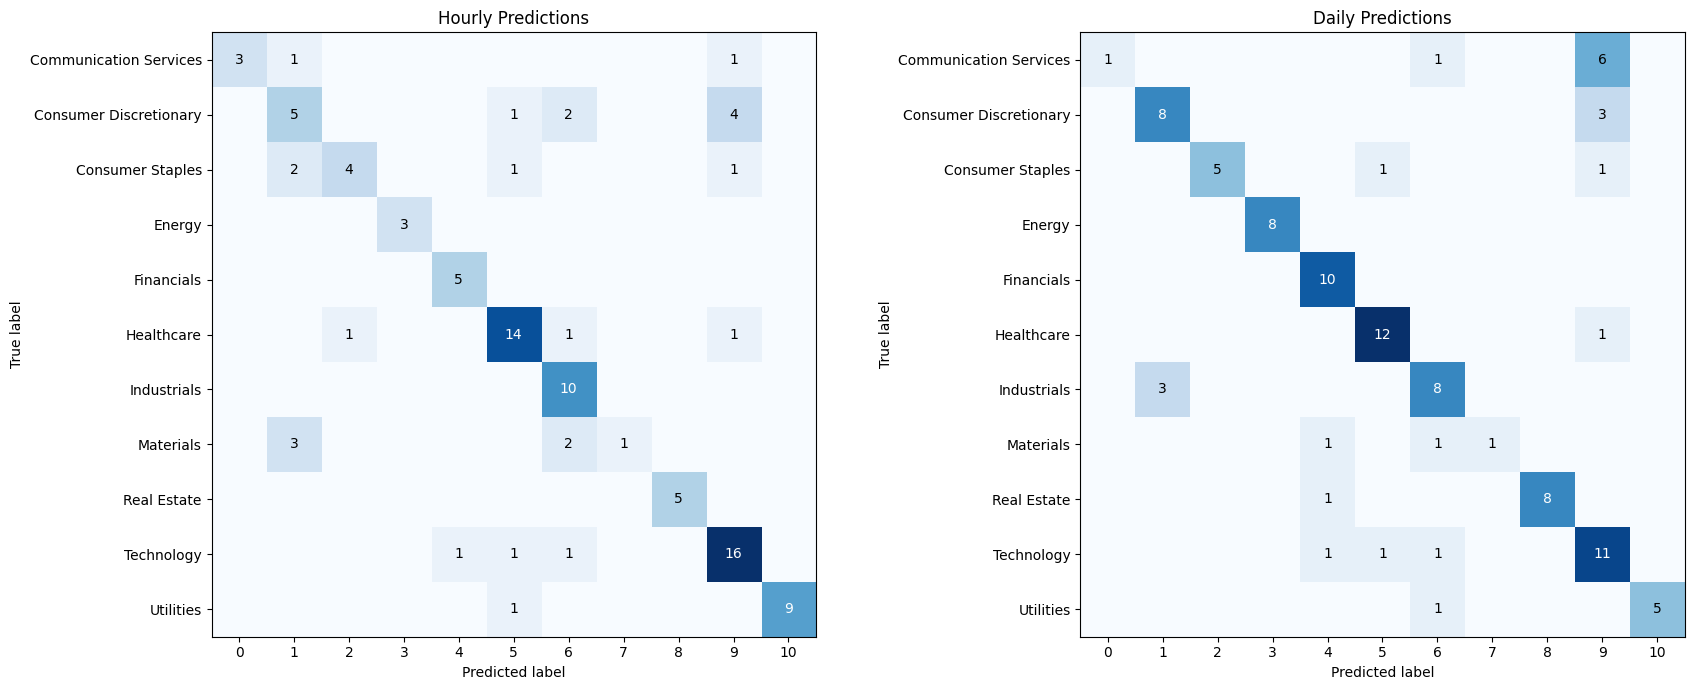

Confusion matrices generated.


In [18]:
run_experiment(get_rfgap_pred, 
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               #n_estimators=1000, max_depth=10, min_samples_split=2, min_samples_leaf=1
               )

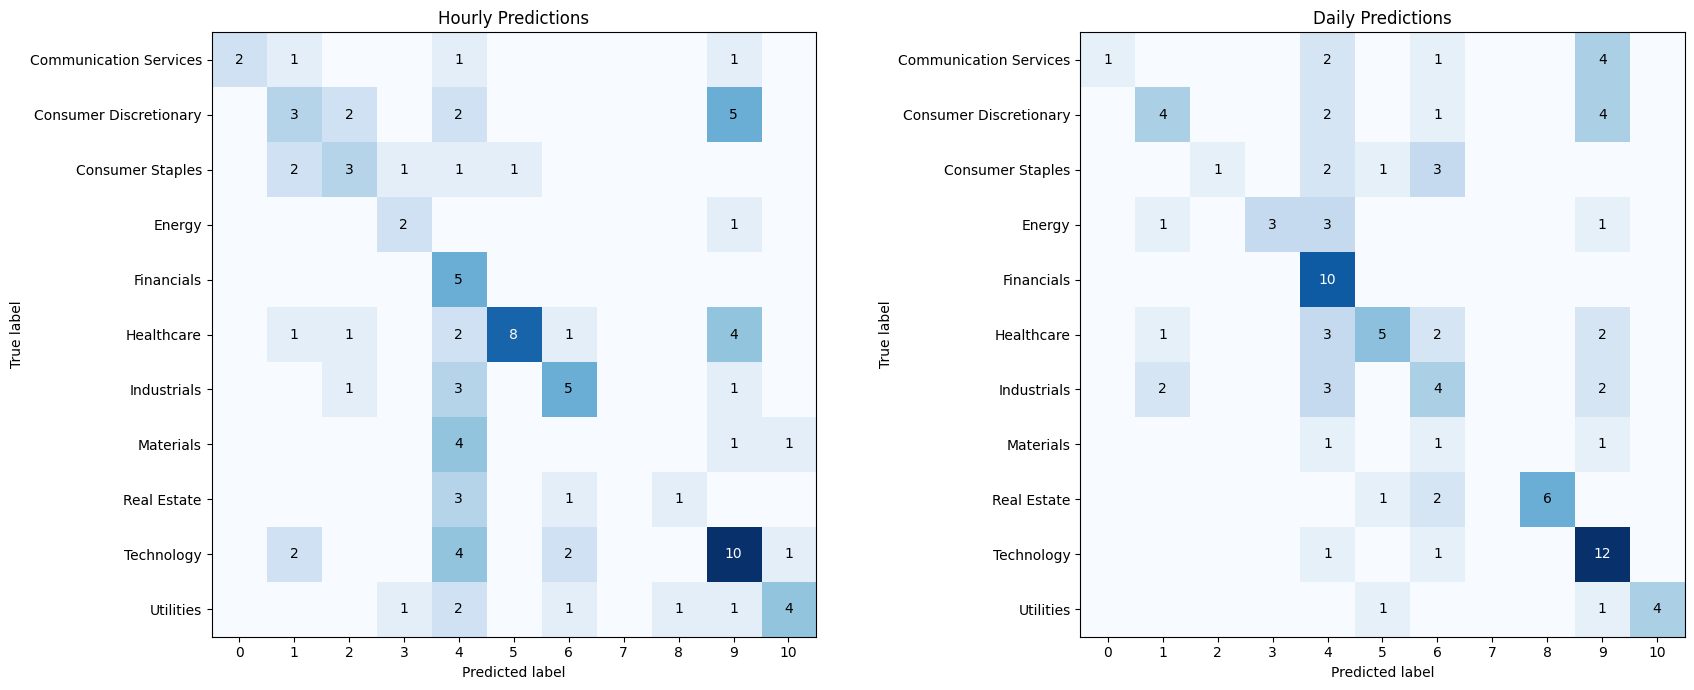

Confusion matrices generated.


In [21]:
run_experiment(get_rocket_pred,
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               #num_kernels=1000, num_features=1000
               prediction_type = "classification"
               )

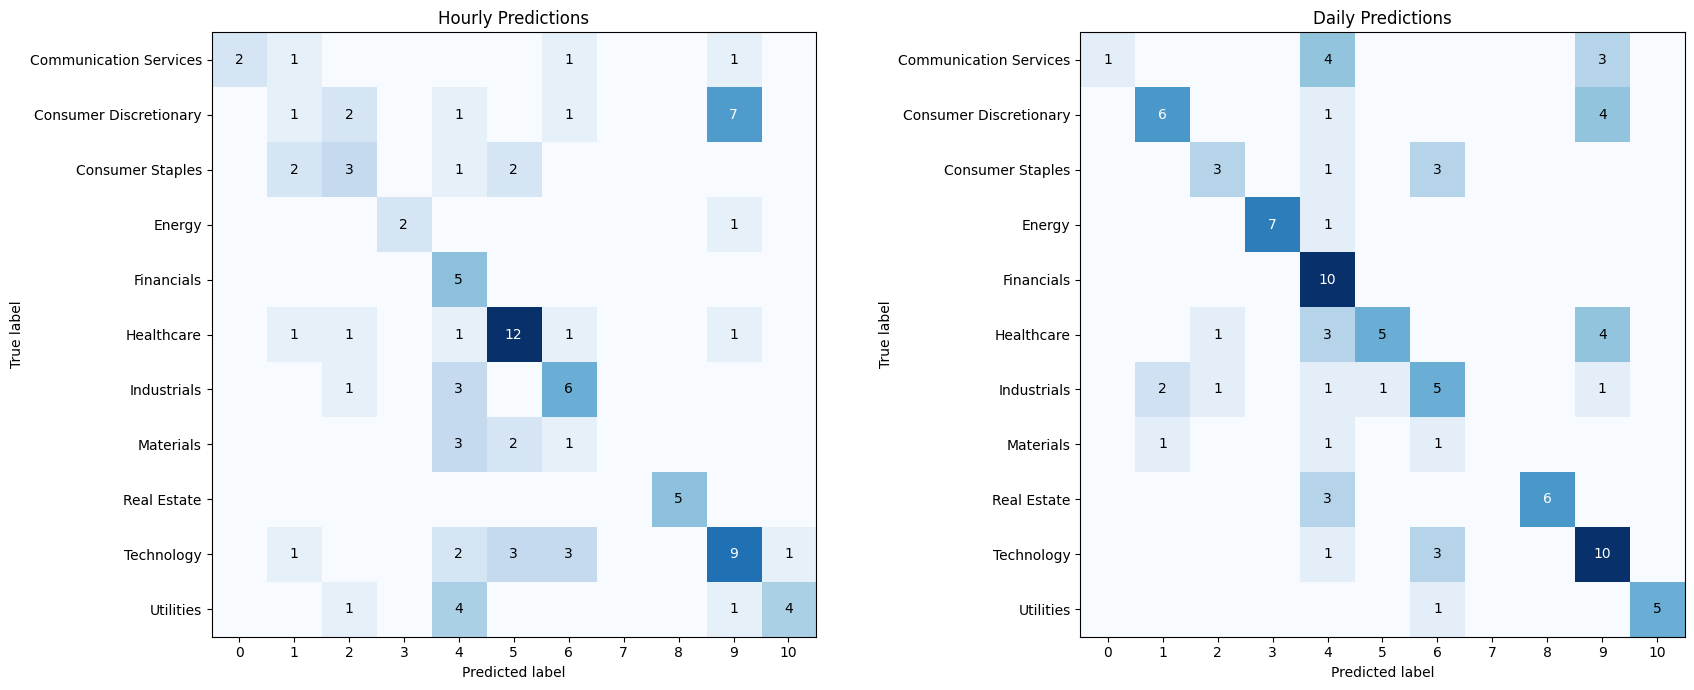

Confusion matrices generated.


In [22]:
run_experiment(get_qgap_pred,
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               prediction_type = "classification"
               )

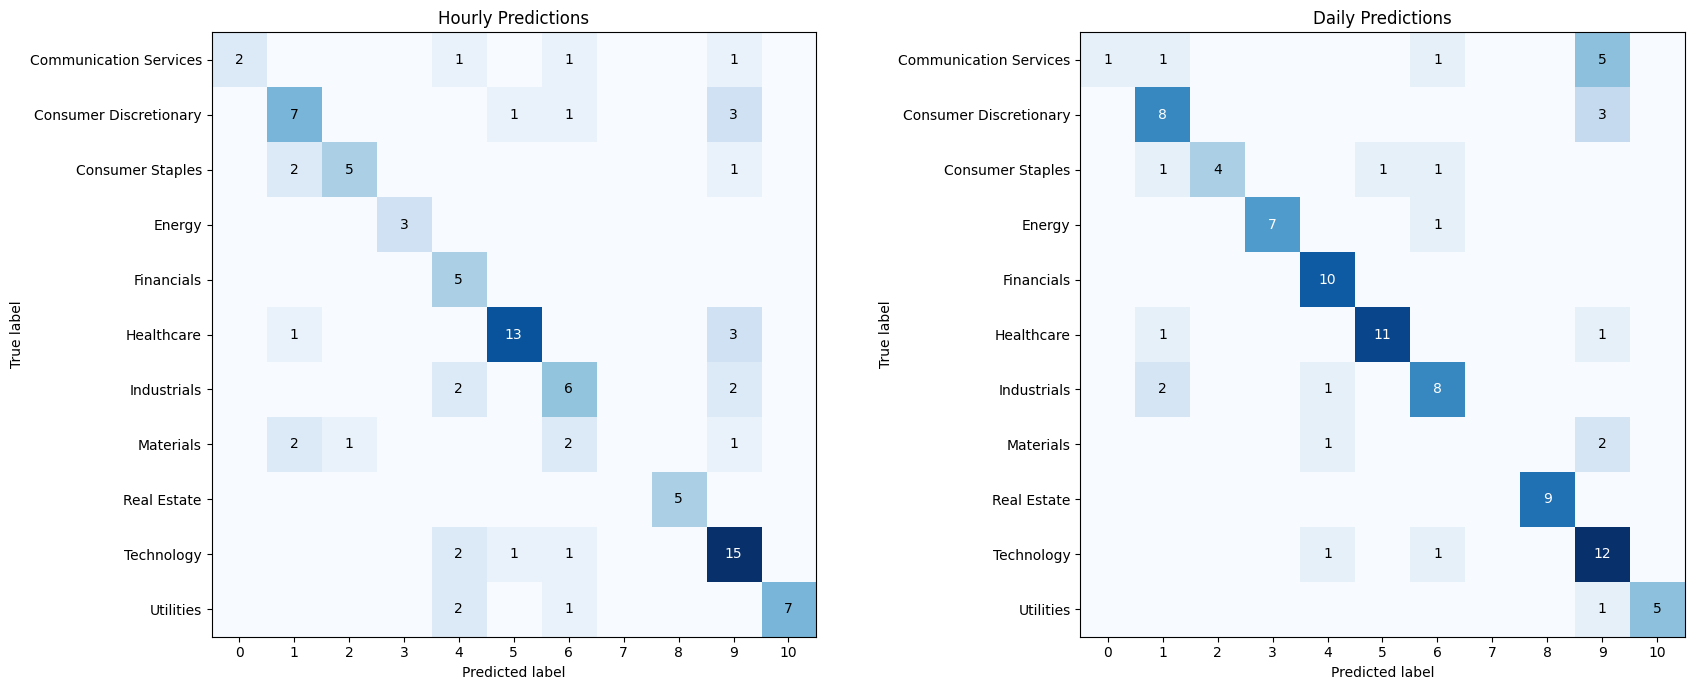

Confusion matrices generated.


In [24]:
run_experiment(get_fresh_pred,
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               )

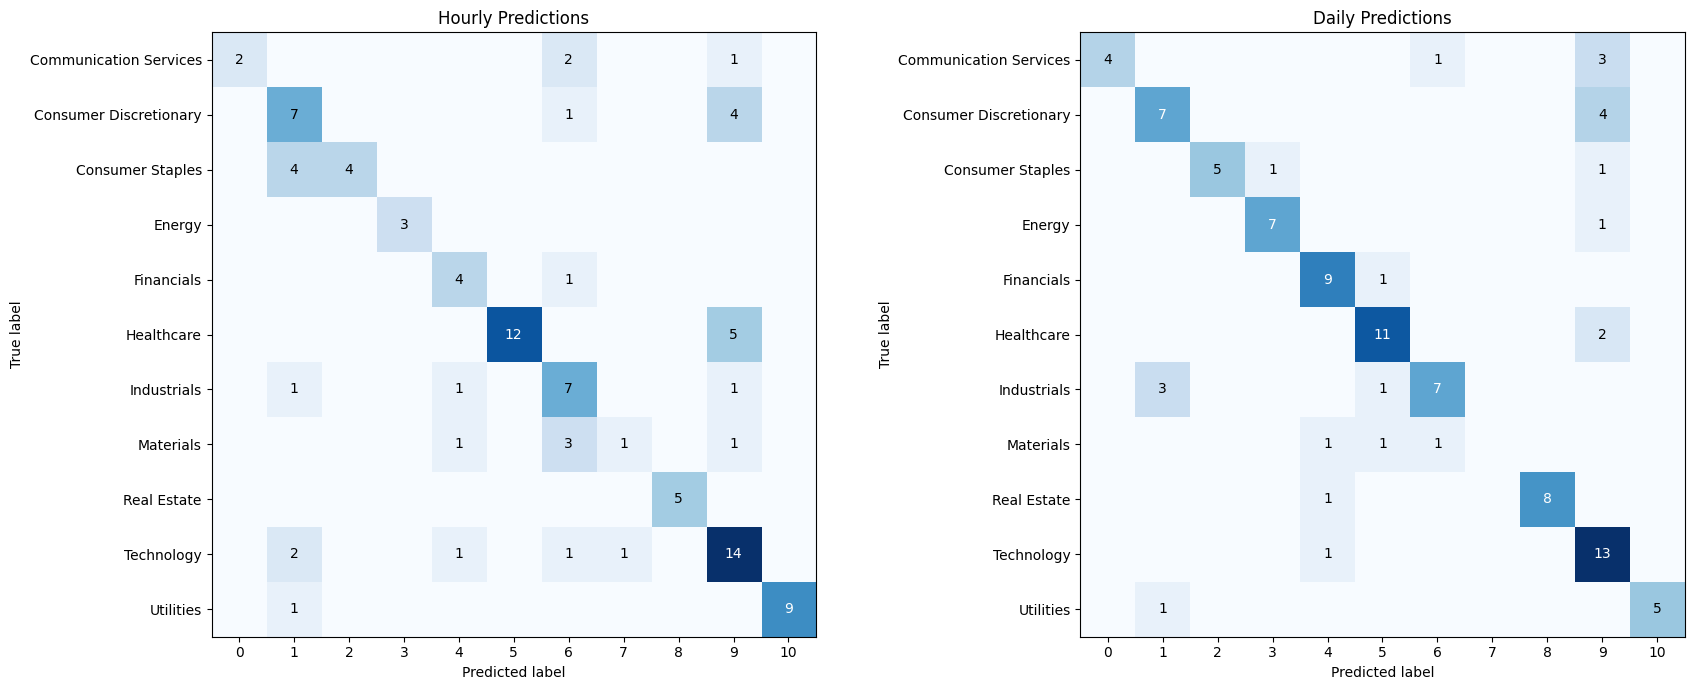

Confusion matrices generated.


In [3]:
run_experiment(get_redcomets_pred,
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               )

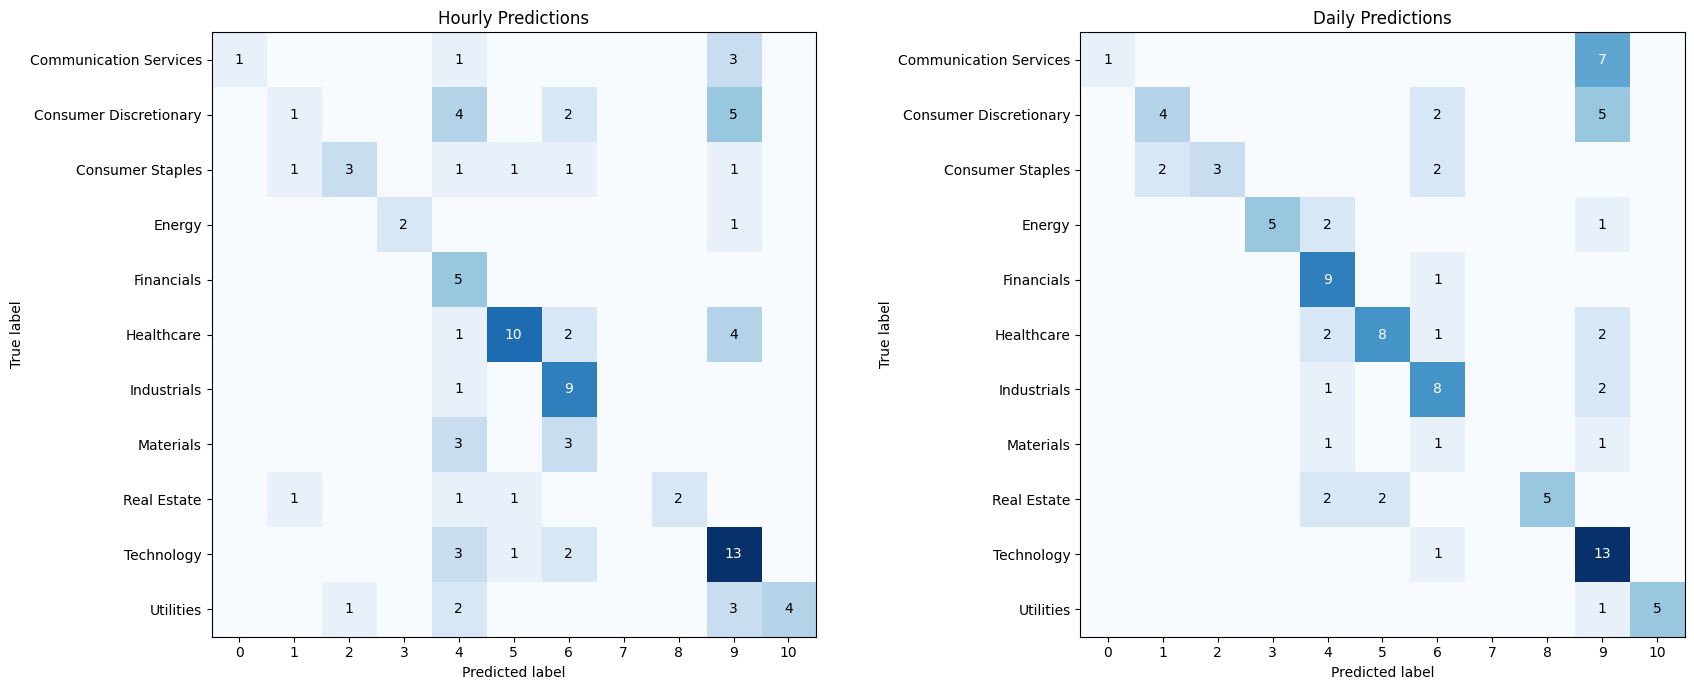

Confusion matrices generated.


In [25]:
run_experiment(get_rdst_pred,
               X_train_hourly, y_train_hourly, X_test_hourly, static_train_hourly, static_test_hourly,
               X_train_daily, y_train_daily, X_test_daily, static_train_daily, static_test_daily,
               )

# Distance measures


In [ ]:
run_distance_experiment(time_series_hourly, labels_hourly, time_series, labels, metric="dtw")

In [ ]:
run_distance_experiment(time_series_hourly, labels_hourly, time_series, labels, metric="euclidean")

In [ ]:
run_distance_experiment(time_series_hourly, labels_hourly, time_series, labels, metric="cosine")